## Goal explanation
In this kernel I want to take a look at predicted value. According [competition data description](https://www.kaggle.com/c/tmdb-box-office-prediction/data)
> You are predicting the worldwide revenue for 4398 movies in the test file.

I've found some [examples](https://www.kaggle.com/c/tmdb-box-office-prediction/discussion/81826#477851) in train data when revenue was equals to US revenue and some examples equals Worldwide revenue.
So I decide to check what we really have in train data.

Start with limport necessary libs

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

Read train and dataset for revenue value check. This dataset was collected from official IMDB website

In [ ]:
train_data = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
revenue_data = pd.read_csv('../input/imdb-revenue-dataset/train_revenue.csv')
train_data = pd.merge(train_data, revenue_data, how='left', on=['imdb_id'])

Some of the films doesn't has information about revenue

In [ ]:
zero_usa_revenue_percent = len(train_data[train_data.usa_revenue==0])/len(train_data)*100
zero_world_revenue_percent = len(train_data[train_data.world_revenue==0])/len(train_data)*100
print("{0:.2f} percent films hasn't USA revenue information".format(zero_usa_revenue_percent))
print("{0:.2f} percent films hasn't World revenue information".format(zero_world_revenue_percent))


let's operate with non zero data

In [ ]:
train_data = train_data[(train_data.usa_revenue > 0) & (train_data.world_revenue > 0)]
print("full revenue information films count: {}".format(len(train_data)))

Let's check what type of revenue is using in train data. Train data can be outdated, therefore tolerance = 5% 

In [ ]:
train_data['is_usa_revenue'] = abs(train_data.revenue - train_data.usa_revenue) < train_data[['revenue', 'usa_revenue']].max(axis=1)*0.05
train_data['is_ww_revenue'] = abs(train_data.revenue - train_data.world_revenue) < train_data[['revenue', 'world_revenue']].max(axis=1)*0.05

In [ ]:
usa_vc = train_data['is_usa_revenue'].value_counts()
ww_vc = train_data['is_ww_revenue'].value_counts()
pd.DataFrame({'true':[usa_vc.get(True), ww_vc.get(True)],
             'false':[ww_vc.get(False), ww_vc.get(False)]},
             index = ['USA revenue','World Revenue']).plot.bar()


Looks like World revenue is more common, but actually this plot is not fully fair. Some films has equals USA and World revenue values and such films don't bring us serious problems.
Let's figure out what exactly films can bring us problems

In [ ]:
train_data['is_only_usa_revenue'] = train_data.is_usa_revenue & ~train_data.is_ww_revenue
train_data['is_only_ww_revenue'] = train_data.is_ww_revenue & ~train_data.is_usa_revenue
train_data['both_revenues'] = train_data.is_usa_revenue & train_data.is_ww_revenue
train_data['strange_revenue'] = ~train_data.is_usa_revenue & ~train_data.is_ww_revenue

In [ ]:
train_data[['is_only_usa_revenue','is_only_ww_revenue','both_revenues','strange_revenue']].sum().plot.bar()

313 films with USA revenue and 387 films with strange revenue(not USA and not a World). Don't forget that we filter all films with zero values.
![](https://www.meme-arsenal.com/memes/629fba7185b55e953449bd41cc83c46f.jpg)



Maybe it's not so critical for us. Let's check it

In [ ]:
train_data['usa_revenue_diff'] = abs(train_data.revenue - train_data.world_revenue)/train_data.revenue
top_error_movies = train_data[train_data.is_only_usa_revenue & (train_data.usa_revenue_diff>0.1)].sort_values(by='usa_revenue_diff',ascending=False)
print(top_error_movies.usa_revenue_diff.describe())

So we have 289 movies with more than 10% error. Look at the top error movies:

In [ ]:
top_error_movies.to_csv('top_error_films.csv',index=False)
top_error_movies[['original_title','imdb_id','revenue','usa_revenue','world_revenue','usa_revenue_diff']].head(20)

As we can see some differences are shocking. 
The main problem is that the same data is using for prediction result validation.
I've collected data for validation data from test.csv and get next results:
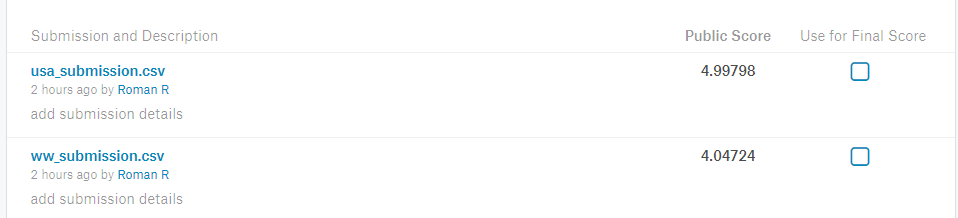

Looks like test data also contains same problem with revenue type(but can not be shured on 100%). Such problem can easily solve in train data, but it's doesn't help if validation is incorrect.

Ofcourse there are some data diffrence on IMDB and TMDB sites, but problem with revenue type is apparent.